In [1]:
# from preprocessing import load_data # locally defined module, see preprocessing.py

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers.experimental import preprocessing
import random
import typing
import collections
import logging
import os
import pathlib
import re
import string
import sys
import time
import pickle

In [2]:
print(os.getcwd())
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f'{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs')
    except RuntimeError as e:
        print(e)

random.seed(218)

logging.getLogger('tensorflow').setLevel(logging.DEBUG)

def log(o):
    logging.getLogger('tensorflow').debug(o)
    
def load_data():
    with open('preprocessed/both_dep.pkl', 'rb') as read_file:
        data = pickle.load(read_file)
        (xtrain, ytrain, xtest, ytest) = data[0]
        return np.concatenate((xtrain, xtest)), np.concatenate((ytrain, ytest))
        

/home/jovyan/ResearchProject/later_experiments
1 Physical GPUs, 1 Logical GPUs


In [3]:
# based on the transformer tutorial from tensorflow: https://www.tensorflow.org/text/tutorials/transformer
samples, labels = load_data()

def split_train_val(samples, labels):
    indices = list(range(len(samples)))
    random.shuffle(indices)
    sep_index = int((len(indices)/5)*4)
    train_indices, val_indices = indices[:sep_index], indices[sep_index:]
    train_samples, train_labels = [samples[i] for i in train_indices], [labels[i] for i  in train_indices]
    val_samples, val_labels = [samples[i] for i in val_indices], [labels[i] for i in val_indices]
    return train_samples, train_labels, val_samples, val_labels

train_samples, train_labels, val_samples, val_labels = split_train_val(samples, labels)
train_samples, train_labels, val_samples, val_labels = tf.constant(train_samples, dtype=tf.float32), tf.constant(train_labels), tf.constant(val_samples, dtype=tf.float32), tf.constant(val_labels)

TRAIN_BUFFER_SIZE = len(train_samples)
VAL_BUFFER_SIZE = len(val_samples)
BATCH_SIZE = 32
train_dataset = tf.data.Dataset.from_tensor_slices((train_samples, train_labels))\
    .shuffle(TRAIN_BUFFER_SIZE)\
    .batch(BATCH_SIZE)
val_dataset = tf.data.Dataset.from_tensor_slices((val_samples, val_labels))\
    .shuffle(VAL_BUFFER_SIZE)\
    .batch(BATCH_SIZE)

In [4]:
log(len(train_dataset))
# taking an example batch for showcasing different steps in during preprocessing data / building the model
for example_input_batch, example_target_batch in train_dataset.take(1):
    log(example_input_batch[:1])
    log('')
    log(example_target_batch[:1])
    log('')


DEBUG:tensorflow:782
DEBUG:tensorflow:tf.Tensor(
[[[-8.03833008e-02  4.76287842e-01 -4.39880371e-01 -1.23413086e-01
   -5.20874023e-01  1.70288086e-01 -8.48388672e-03  4.91333008e-02
    2.38037109e-02 -1.95312500e-02  1.45751953e-01  1.11572266e-01
   -9.28710938e-01]
  [-6.86931610e-02  4.09288406e-01 -3.32969666e-01 -9.46769714e-02
   -4.04487610e-01  2.78434753e-01  2.39601135e-02  1.45778656e-02
    2.68936157e-02 -1.93252563e-02  1.45957947e-01  1.12190247e-01
   -8.91632080e-01]
  [-6.92558289e-02  4.08231735e-01 -3.02030563e-01 -3.90014648e-02
   -3.96110535e-01  3.80874634e-01  2.18276978e-02  2.43339539e-02
    2.66685486e-02 -1.86157227e-02  1.44989014e-01  1.12640381e-01
   -8.56567383e-01]
  [-4.01620865e-02  3.89558792e-01 -3.19534302e-01 -1.56593323e-02
   -3.89453888e-01  3.67233276e-01  9.40513611e-03  3.08666229e-02
    2.06642151e-02 -1.80511475e-02  1.45179749e-01  1.12533569e-01
   -8.21182251e-01]
  [-4.71343994e-02  4.06021118e-01 -2.95455933e-01  7.44628906e-03


In [5]:
## text tokenization
def tf_lower_and_split_punct(text): # name of the function is from example on https://www.tensorflow.org/text/tutorials/nmt_with_attention#the_encoderdecoder_model
    # Add spaces around every item in the text.
    text = tf.strings.regex_replace(text, '.', r'\0 ')
    # Strip whitespace.
    text = tf.strings.strip(text)

    text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
    return text

output_text_processor = preprocessing.TextVectorization(
    standardize=tf_lower_and_split_punct,
    )
output_text_processor.adapt(train_labels)
log(output_text_processor.get_vocabulary())

example_target_tokens = output_text_processor(example_target_batch)

DEBUG:tensorflow:['', '[UNK]', '[START]', '[END]', 'S', 'k', 'M', 'h', 'J', 'r', 'p', 'i', 'z', 'G', 'A', 'l', 'H', 'D', 'q', 't', 'Q', 'C', 'W', 'U', 's', 'd', 'u', 'P', 'B', 'x', 'X', 'F', 'w', 'Z', 'R', 'I', 'E', 'b', 'Y', 'y', 'v', 'm', 'N', 'e', 'K', 'V', 'o', 'T', 'j', 'g', 'f', 'c', 'L', 'n', 'a', 'O']


Text(0.5, 1.0, 'Mask')

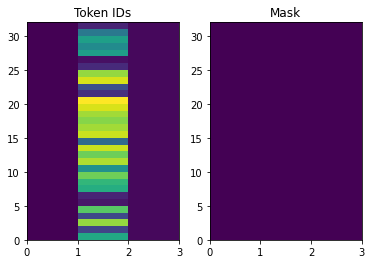

In [6]:
plt.subplot(1,2,1)
plt.pcolormesh(example_target_tokens)
plt.title('Token IDs')

plt.subplot(1,2,2)
plt.pcolormesh(example_target_tokens != 0)
plt.title('Mask')


In [7]:
EMBEDDING_DIM = 128
UNITS = 1024
HEADS = 8
log(example_target_tokens[:5])


def tokenize(labels_batch):
    return output_text_processor(labels_batch)

def detokenize(tokens_batch):
    detokenizer = np.array(output_text_processor.get_vocabulary())
    def _detokenize(tokens):
        return ''.join(detokenizer[tokens.numpy()])
    return tf.map_fn(_detokenize, tokens_batch, dtype=tf.string)

log(detokenize(example_target_tokens)[:5])
# log(np.array(output_text_processor.get_vocabulary())[example_target_tokens[0].numpy()])

DEBUG:tensorflow:tf.Tensor(
[[ 2 32  3]
 [ 2 12  3]
 [ 2 44  3]
 [ 2 13  3]
 [ 2 39  3]], shape=(5, 3), dtype=int64)
DEBUG:tensorflow:tf.Tensor(
[b'[START]w[END]' b'[START]z[END]' b'[START]K[END]' b'[START]G[END]'
 b'[START]y[END]'], shape=(5,), dtype=string)


In [8]:
def tokenize_dataset(ds):
    return(ds
           .cache()
           .map(lambda x, y: (x,tokenize(y))))
train_batches = tokenize_dataset(train_dataset)
val_batches = tokenize_dataset(val_dataset)

DEBUG:tensorflow:(1, 1024, 128)


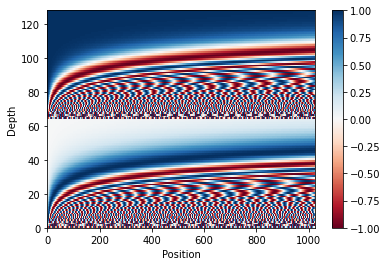

In [9]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

n, d = UNITS, EMBEDDING_DIM
pos_encoding = positional_encoding(n, d)
log(pos_encoding.shape)

# juggling the dimensions for the plot seems to be quite hard, since 13 % 2 != 0, so the values cannot be neatly put into two parts of the plot.
pos_encoding = pos_encoding[0]
pos_encoding = tf.reshape(pos_encoding, (n, d//2, 2))
pos_encoding = tf.transpose(pos_encoding, (2, 1, 0))
pos_encoding = tf.reshape(pos_encoding, (d, n))


plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

In [10]:
def pad_input_sensor_data(seq, d_model):
    seq = tf.pad(seq, tf.constant([[0,0],[0,0],[0, d_model-13]]), 'CONSTANT')
    return seq

def create_input_padding_mask(seq):
    seq = tf.cast(tf.reduce_all(tf.math.equal(seq, tf.zeros((13))), axis=2), dtype=tf.float32)
#     log(seq)
    return seq[:, tf.newaxis, tf.newaxis, :]

x = tf.random.uniform((2, 2, 13), dtype=tf.float32, minval=-1, maxval=1)
temp_x = tf.constant(tf.repeat(tf.zeros(13),2))
x = tf.concat((x, [tf.constant(tf.repeat([tf.zeros(13)],2, axis=0))]), axis=0)
# log(x)
log(create_input_padding_mask(x))

def create_token_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
log(create_token_padding_mask(x))

def create_token_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

x = tf.random.uniform((1,3))
temp = create_token_look_ahead_mask(x.shape[1])
log(temp)

DEBUG:tensorflow:tf.Tensor(
[[[[0. 0.]]]


 [[[0. 0.]]]


 [[[1. 1.]]]], shape=(3, 1, 1, 2), dtype=float32)
DEBUG:tensorflow:tf.Tensor(
[[[[0. 0. 1. 1. 0.]]]


 [[[0. 0. 0. 1. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(3, 1, 1, 5), dtype=float32)
DEBUG:tensorflow:tf.Tensor(
[[0. 1. 1.]
 [0. 0. 1.]
 [0. 0. 0.]], shape=(3, 3), dtype=float32)


In [11]:
############## scaled dot product attention
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    output = tf.matmul(attention_weights, v)
    return output, attention_weights

def print_out(q, k, v):
    temp_out, temp_attn = scaled_dot_product_attention(
        q, k, v, None
    )
    log(f'Attention weights: {temp_attn}')
    log(f'Output is: {temp_out}')

np.set_printoptions(suppress=True)

temp_k = tf.constant([[10, 0, 0],
                      [0, 10, 0],
                      [0, 0, 10],
                      [0, 0, 10]], dtype=tf.float32)

temp_v = tf.constant([[1, 0],
                      [10, 0],
                      [100, 5],
                      [1000, 6]], dtype=tf.float32)

temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)
print_out(temp_q, temp_k, temp_v)

log('')

temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)
print_out(temp_q, temp_k, temp_v)

log('')
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)
print_out(temp_q, temp_k, temp_v)

log('')
temp_q = tf.constant([[0, 0, 10],
                      [0, 10, 0],
                      [10, 10, 0]], dtype=tf.float32)
print_out(temp_q, temp_k, temp_v)

DEBUG:tensorflow:Attention weights: [[0. 1. 0. 0.]]
DEBUG:tensorflow:Output is: [[10.  0.]]
DEBUG:tensorflow:
DEBUG:tensorflow:Attention weights: [[0.  0.  0.5 0.5]]
DEBUG:tensorflow:Output is: [[550.    5.5]]
DEBUG:tensorflow:
DEBUG:tensorflow:Attention weights: [[0.5 0.5 0.  0. ]]
DEBUG:tensorflow:Output is: [[5.5 0. ]]
DEBUG:tensorflow:
DEBUG:tensorflow:Attention weights: [[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]]
DEBUG:tensorflow:Output is: [[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]]


In [12]:
################### multi-head attention

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        assert d_model % self.num_heads == 0
        self.depth = d_model // self.num_heads
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
#         log(v.get_shape())
#         log(k.get_shape())
#         log(q.get_shape())
#         if mask is not None:
#             log(mask.get_shape())
        batch_size = tf.shape(q)[0]
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask
        )
        scaled_attention = tf.transpose(scaled_attention, perm=[0,2,1,3])
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)
        return output, attention_weights

In [13]:
temp_mha = MultiHeadAttention(d_model=EMBEDDING_DIM, num_heads=HEADS)
y = tf.random.uniform((1, 60, EMBEDDING_DIM))
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape


(TensorShape([1, 60, 128]), TensorShape([1, 8, 60, 60]))

In [14]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),
        tf.keras.layers.Dense(d_model)
    ])

sample_ffn = point_wise_feed_forward_network(EMBEDDING_DIM, UNITS)
log(sample_ffn(tf.random.uniform((32, 200, EMBEDDING_DIM))).shape)

DEBUG:tensorflow:(32, 200, 128)


In [15]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)
        
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)
        return out2

sample_encoder_layer = EncoderLayer(EMBEDDING_DIM, HEADS, UNITS)
sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((32, 200, EMBEDDING_DIM), minval=-1, maxval=1), False, None
)
log(sample_encoder_layer_output.shape)

DEBUG:tensorflow:(32, 200, 128)


In [16]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()
        
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)
        
        self.ffn = point_wise_feed_forward_network(d_model,dff)
        
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)
        
        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask
        )
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)
        
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)
        
        return out3, attn_weights_block1, attn_weights_block2

sample_decoder_layer = DecoderLayer(EMBEDDING_DIM, HEADS, UNITS)
sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((32, 200, EMBEDDING_DIM)), sample_encoder_layer_output,
    False, None, None
)
log(sample_decoder_layer_output.shape)

DEBUG:tensorflow:(32, 200, 128)


In [17]:
class SensorFeatureEmbedding(layers.Layer):
    def __init__(self, dim_emb, maxlen=2000):
        super().__init__()
        kernel_size = 10
        num_hid=dim_emb
        self.conv1 = tf.keras.layers.Conv1D(num_hid, kernel_size, strides=2, padding="same", activation="relu")
        self.conv2 = tf.keras.layers.Conv1D(num_hid, kernel_size, strides=2, padding="same", activation="relu")
#         self.conv3 = tf.keras.layers.Conv1D(num_hid, kernel_size, strides=2, padding="same", activation="relu")
#         self.ffn = point_wise_feed_forward_network(dim_emb, num_hid)

    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
#         x = self.ffn(x)
        return x

In [18]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()
        self.num_layers = num_layers
        self.d_model = d_model
        self.num_heads = num_heads
        self.dff = dff
        self.rate = rate
        self.maximum_position_encoding = maximum_position_encoding
        self.embedding = SensorFeatureEmbedding(d_model)
#         self.embedding = point_wise_feed_forward_network(self.d_model, 13)
        self.pos_encoding = positional_encoding(self.maximum_position_encoding,
                                              self.d_model)
        self.enc_layers = [EncoderLayer(self.d_model, self.num_heads, self.dff, self.rate)
                           for _ in range(self.num_layers)]
        self.dropout = tf.keras.layers.Dropout(self.rate)

    def call(self, x, training, mask):
        # no embedding needed, since sensor data is already a really dense representation
        x = self.embedding(x)
        seq_len = tf.shape(x)[1]
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
        return x


sample_encoder = Encoder(num_layers=2, d_model=EMBEDDING_DIM, num_heads=HEADS,
                         dff=UNITS, maximum_position_encoding=10000)

temp_input = tf.random.uniform((32, 200, 13), dtype=tf.float32, minval=-1, maxval=1)
sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)
log(sample_encoder_output.shape)

DEBUG:tensorflow:(32, 50, 128)


In [19]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
                 maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()
        self.num_layers = num_layers
        self.d_model = d_model
        self.num_heads = num_heads
        self.dff = dff
        self.target_vocab_size = target_vocab_size
        self.maximum_position_encoding = maximum_position_encoding
        self.rate = rate
        self.embedding = tf.keras.layers.Embedding(self.target_vocab_size, self.d_model)
        self.pos_encoding = positional_encoding(self.maximum_position_encoding, self.d_model)
        self.dec_layers = [DecoderLayer(self.d_model, self.num_heads, self.dff, self.rate)
                           for _ in range(self.num_layers)]
        self.dropout = tf.keras.layers.Dropout(self.rate)

    def call(self, x, enc_output, training,
             look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x += self.dropout(x, training=training)
        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                   look_ahead_mask, padding_mask)
            attention_weights[f'decoder_layer{i+1}_block1'] = block1
            attention_weights[f'decoder_layer{i+1}_block2'] = block2
        return x, attention_weights


sample_decoder = Decoder(num_layers=2, d_model=EMBEDDING_DIM, num_heads=HEADS,
                         dff=UNITS, target_vocab_size=len(output_text_processor.get_vocabulary()),
                         maximum_position_encoding=100)
temp_target = tf.random.uniform((32, 10), dtype=tf.int64, minval=0, maxval=8)
output, attn = sample_decoder(temp_target,
                              enc_output=sample_encoder_output,
                              training=False,
                              look_ahead_mask=None,
                              padding_mask=None)
log((output.shape, attn['decoder_layer1_block2'].shape))

DEBUG:tensorflow:(TensorShape([32, 10, 128]), TensorShape([32, 8, 10, 50]))


In [20]:

class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
                 pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()
        self.encoder = Encoder(num_layers, d_model, num_heads, dff,
                               pe_input, rate)
        self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                               target_vocab_size, pe_target, rate)
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inp, tar, training, enc_padding_mask,
             look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, training, None)
        dec_output, attention_weights = self.decoder(
            tar, enc_output, training, look_ahead_mask, None
        )
        final_output = self.final_layer(dec_output)
        return final_output, attention_weights

sample_transformer = Transformer(
    num_layers=2, d_model=EMBEDDING_DIM, num_heads=HEADS, dff=UNITS,
    target_vocab_size=len(output_text_processor.get_vocabulary()), pe_input=10000,
    pe_target=100 # because it's a written equation, we will probably not ever reach this number
)
temp_input = tf.random.uniform((32, 200, EMBEDDING_DIM), dtype=tf.float32, minval=-1, maxval=1)
temp_target = tf.random.uniform((32, 10), dtype=tf.int64, minval=0, maxval=8)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False,
                               enc_padding_mask=None,
                               look_ahead_mask=None,
                               dec_padding_mask=None)

log(fn_out.shape)

DEBUG:tensorflow:(32, 10, 56)


In [21]:
num_layers = 1
d_model = EMBEDDING_DIM
dff = UNITS
num_heads = HEADS
dropout_rate = 0.1

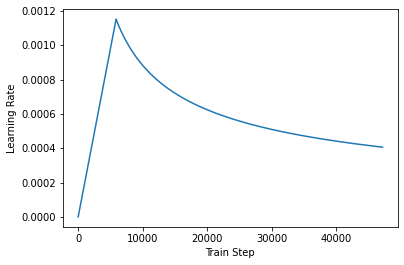

In [22]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_epochs=15, steps_per_epoch=392):
        super(CustomSchedule, self).__init__()
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_epochs = warmup_epochs
        self.warmup_steps = warmup_epochs * steps_per_epoch

    def __call__(self, step):
        arg1 = 1/tf.math.pow(step, 0.5)
        arg2 = step * (self.warmup_steps ** -1.5)
#         arg2 = tf.constant(1.0)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


# class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
#     def __init__(
#         self,
#         init_lr=0.0001,
#         lr_after_warmup=0.001,
#         final_lr=0.00001,
#         warmup_epochs=30,
#         decay_epochs=85,
#         steps_per_epoch=236,
#     ):
#         super().__init__()
#         self.init_lr = init_lr
#         self.lr_after_warmup = lr_after_warmup
#         self.final_lr = final_lr
#         self.warmup_epochs = warmup_epochs
#         self.decay_epochs = decay_epochs
#         self.steps_per_epoch = steps_per_epoch

#     def calculate_lr(self, epoch):
#         """ linear warm up - linear decay """
#         warmup_lr = (
#             self.init_lr
#             + ((self.lr_after_warmup - self.init_lr) / (self.warmup_epochs - 1)) * epoch
#         )
#         decay_lr = tf.math.maximum(
#             self.final_lr,
#             self.lr_after_warmup
#             - (epoch - self.warmup_epochs)
#             * (self.lr_after_warmup - self.final_lr)
#             / (self.decay_epochs),
#         )
#         return tf.math.minimum(warmup_lr, decay_lr)

#     def __call__(self, step):
#         epoch = step // self.steps_per_epoch
#         return self.calculate_lr(epoch)

    
temp_learning_rate_schedule = CustomSchedule(d_model)
plt.plot(temp_learning_rate_schedule(tf.range(236*200, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')


learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

In [23]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none'
)

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

def accuracy_function(real, pred):
    accuracies = tf.equal(real, tf.argmax(pred, axis=2))
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)
    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')
val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = tf.keras.metrics.Mean(name='val_accuracy')

transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    target_vocab_size=len(output_text_processor.get_vocabulary()),
    pe_input=2000,
    pe_target=100,
    rate=dropout_rate
)

def create_masks(inp, tar):
    enc_padding_mask = create_input_padding_mask(inp)
    dec_padding_mask = create_input_padding_mask(inp)
    look_ahead_mask = create_token_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_token_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
    return enc_padding_mask, combined_mask, dec_padding_mask

checkpoint_path = './checkpoints/train'
ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!!')
    


EPOCHS = 75
train_step_signature = [
    tf.TensorSpec(shape=(None, None, 13), dtype=tf.float32),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

val_step_signature = [
    tf.TensorSpec(shape=(None, None, 13), dtype=tf.float32),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
#     inp = pad_input_sensor_data(inp)
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp,
                                     True,
                                     enc_padding_mask,
                                     combined_mask,
                                     dec_padding_mask)
        loss = loss_function(tar_real, predictions)
    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
    train_loss(loss)
    train_accuracy(accuracy_function(tar_real, predictions))

@tf.function(input_signature=val_step_signature)
def val_step(inp, tar):
#     inp = pad_input_sensor_data(inp)
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
    predictions, _ = transformer(inp, tar_inp,
                                False,
                                enc_padding_mask,
                                combined_mask,
                                dec_padding_mask)
    val_loss(loss_function(tar_real, predictions))
    val_accuracy(accuracy_function(tar_real, predictions))

train_metrics = {
    'loss': [],
    'accuracy': [],
}
val_metrics = {
    'loss': [],
    'accuracy': [],
}
for epoch in range(EPOCHS):
    counted_vars=False
    start = time.time()
    train_loss.reset_states()
    train_accuracy.reset_states()
    val_loss.reset_states()
    val_accuracy.reset_states()
    for (train_batch, (inp, tar)) in enumerate(train_batches):
        train_step(inp, tar)
        if train_batch % 50 == 0:
            print(f'Epoch {epoch + 1} Batch {train_batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')
    for (val_batch, (val_inp, val_tar)) in enumerate(val_batches):
        val_step(val_inp, val_tar)
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print(f'Saving checkpoint for epoch {epoch + 1} at {ckpt_save_path}')
#     print(f'Training steps the optimizer has ran: {optimizer.iterations}')
    train_loss_res = train_loss.result()
    train_accuracy_res = train_accuracy.result()
    val_loss_res = val_loss.result()
    val_accuracy_res = val_accuracy.result()
    train_metrics['loss'].append(train_loss_res)
    train_metrics['accuracy'].append(train_accuracy_res)
    val_metrics['loss'].append(val_loss_res)
    val_metrics['accuracy'].append(val_accuracy_res)
    print(f'Epoch {epoch + 1} Loss {train_loss_res: >17.4f} Accuracy {train_accuracy_res: >17.4f}')
    print(f'Epoch {epoch + 1} Validation Loss {val_loss_res:.4f} Validation Accuracy {val_accuracy_res:.4f}')
    print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

# note to self: keep in mind that this has ran for .. epochs already, before adding validation accuracy and restarting from the saved checkpoint. So, add that number to the number of epochs that is indicated in the logs.

Epoch 1 Batch 0 Loss 4.3431 Accuracy 0.0000
Epoch 1 Batch 50 Loss 3.9487 Accuracy 0.0830
Epoch 1 Batch 100 Loss 3.3807 Accuracy 0.2887
Epoch 1 Batch 150 Loss 3.1069 Accuracy 0.3587
Epoch 1 Batch 200 Loss 2.9042 Accuracy 0.3938
Epoch 1 Batch 250 Loss 2.7482 Accuracy 0.4158
Epoch 1 Batch 300 Loss 2.6347 Accuracy 0.4306
Epoch 1 Batch 350 Loss 2.5506 Accuracy 0.4424
Epoch 1 Batch 400 Loss 2.4853 Accuracy 0.4507
Epoch 1 Batch 450 Loss 2.4334 Accuracy 0.4577
Epoch 1 Batch 500 Loss 2.3906 Accuracy 0.4632
Epoch 1 Batch 550 Loss 2.3560 Accuracy 0.4677
Epoch 1 Batch 600 Loss 2.3251 Accuracy 0.4717
Epoch 1 Batch 650 Loss 2.2970 Accuracy 0.4748
Epoch 1 Batch 700 Loss 2.2715 Accuracy 0.4778
Epoch 1 Batch 750 Loss 2.2480 Accuracy 0.4803
Epoch 1 Loss            2.2340 Accuracy            0.4820
Epoch 1 Validation Loss 1.8686 Validation Accuracy 0.5314
Time taken for 1 epoch: 48.87 secs

Epoch 2 Batch 0 Loss 1.9509 Accuracy 0.5312
Epoch 2 Batch 50 Loss 1.8826 Accuracy 0.5263
Epoch 2 Batch 100 Loss 1.8

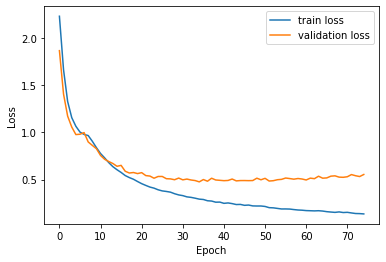

max train accuracy: 0.9493374824523926
max val accuracy: 0.8655505776405334


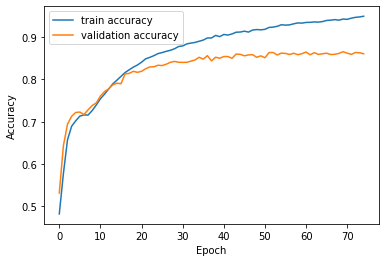

In [24]:

plt.plot(train_metrics['loss'])
plt.plot(val_metrics['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train loss', 'validation loss'])
plt.show()

print(f'max train accuracy: {max(train_metrics["accuracy"])}')
print(f'max val accuracy: {max(val_metrics["accuracy"])}')
plt.plot(train_metrics['accuracy'])
plt.plot(np.array(val_metrics['accuracy']))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train accuracy', 'validation accuracy'])
plt.show()

DEBUG:tensorflow:tf.Tensor(b'[START]139717=96[END]', shape=(), dtype=string)
DEBUG:tensorflow:['[START]' '1' '3' '9' '7' '1' '7' '=' '9' '6' '[END]']
DEBUG:tensorflow:Prediction     : b'[START]139717=96[END]'
DEBUG:tensorflow:Ground truth   : b'139717=90'


<ipython-input-37-6c14550032c8>:28: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  tokens = np.array(output_text_processor.get_vocabulary())[output]


DEBUG:tensorflow:tf.Tensor(b'[START]72:22512+4[END]', shape=(), dtype=string)
DEBUG:tensorflow:['[START]' '7' '2' ':' '2' '2' '5' '1' '2' '+' '4' '[END]']
DEBUG:tensorflow:Prediction     : b'[START]72:22512+4[END]'
DEBUG:tensorflow:Ground truth   : b'72:22512+4'
DEBUG:tensorflow:tf.Tensor(b'[START]4164251:859[END]', shape=(), dtype=string)
DEBUG:tensorflow:['[START]' '4' '1' '6' '4' '2' '5' '1' ':' '8' '5' '9' '[END]']
DEBUG:tensorflow:Prediction     : b'[START]4164251:859[END]'
DEBUG:tensorflow:Ground truth   : b'4104251:859'
DEBUG:tensorflow:(12, 333)
DEBUG:tensorflow:tf.Tensor(
[[[-0.14572144  0.4401245  -0.23019409 ...  0.0592041  -0.02331543
   -0.8183594 ]
  [-0.14984131  0.51293945 -0.16333008 ...  0.05969238 -0.02282715
   -0.7006836 ]
  [-0.13900757  0.46844482 -0.17324829 ...  0.05969238 -0.02319336
   -0.61621094]
  ...
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0. 

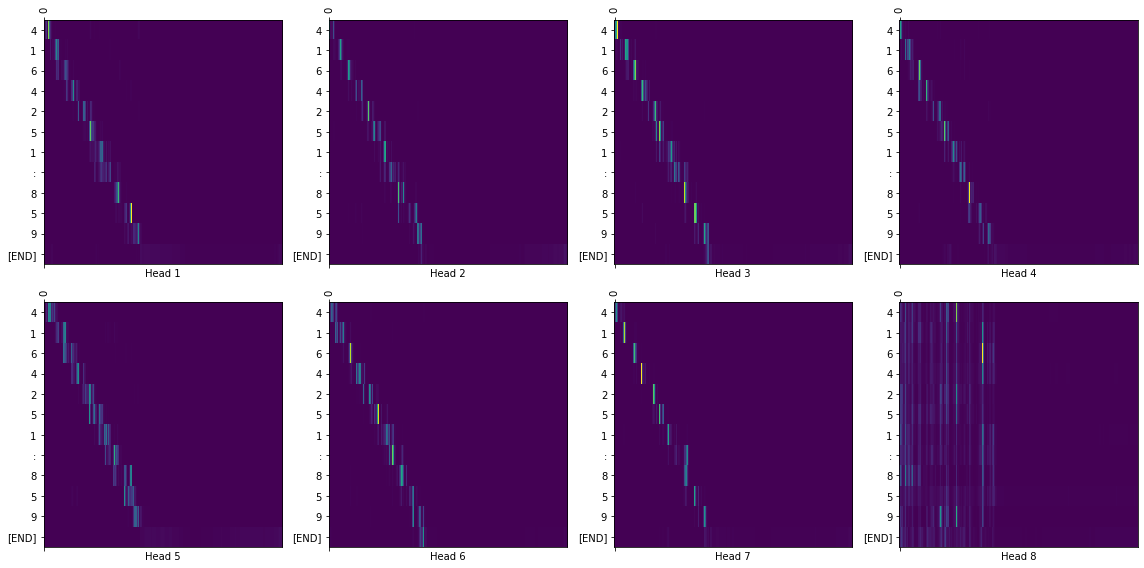

In [37]:
### if ckpt_manager.latest_checkpoint:
#     ckpt.restore(ckpt_manager.latest_checkpoint)
#     print('Latest checkpoint restored!!')
    
def evaluate(sentence, max_length=40):
    sentence = tf.convert_to_tensor([sentence])
    encoder_input = sentence
    start, end = tokenize([''])[0]
    output = tf.convert_to_tensor([start])
    output = tf.expand_dims(output,0)
    for i in range(max_length):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
            encoder_input, output
        )
        predictions, attention_weights = transformer(encoder_input,
                                                     output,
                                                     False,
                                                     enc_padding_mask,
                                                     combined_mask,
                                                     dec_padding_mask)
        predictions = predictions[:, -1:, :]
        predicted_id = tf.argmax(predictions, axis=-1)
        output = tf.concat([output, predicted_id], axis=-1)
        if predicted_id == end:
            break
    text = detokenize(output)[0]
    log(text)
    tokens = np.array(output_text_processor.get_vocabulary())[output]
    log(tokens)
    return text, tokens, attention_weights

def print_translation(sentence, text, ground_truth):
#     log(f'{"Input:":15s}: {sentence}')
    log(f'{"Prediction":15s}: {text}')
    log(f'{"Ground truth":15s}: {ground_truth}')

for i in range(3):
    sentence = val_samples[i]
    ground_truth = val_labels[i]
    translated_text, translated_tokens, attention_weights = evaluate(sentence)
    print_translation(sentence, translated_text, ground_truth)

def plot_attention_head(in_data, translated_tokens, attention):
    translated_tokens = translated_tokens[1:]
    ax = plt.gca()
    ax.matshow(attention, aspect='auto')
    ax.set_xticks(range(len(in_data)))
    ax.set_yticks(range(len(translated_tokens)))
    labels = [i for i in range(len(in_data.numpy()))]
    ax.set_xticklabels(
        labels, rotation=90
    )
    labels = [label for label in translated_tokens]
    ax.set_yticklabels(labels)

head = 0
attention_heads = tf.squeeze(
    attention_weights['decoder_layer2_block2'], 0)
attention = attention_heads[head]
log(attention.shape)

in_data = tf.convert_to_tensor([sentence])
log(in_data)
log(translated_tokens)
# plot_attention_head(tf.range(333), translated_tokens, attention)

def plot_attention_weights(sentence, translated_tokens, attention_heads):
    in_data = tf.convert_to_tensor([sentence])
    log(in_data)
    fig = plt.figure(figsize=(16,8))
    for h, head in enumerate(attention_heads):
        ax = fig.add_subplot(2, 4, h+1)
        plot_attention_head(in_data, translated_tokens, head)
        ax.set_xlabel(f'Head {h+1}')
    plt.tight_layout()
    plt.show()

plot_attention_weights(sentence, translated_tokens,
                       attention_weights['decoder_layer2_block2'][0])
